In [101]:
import numpy as np
from scipy.stats import norm, cauchy, truncnorm
from scipy.special import factorial2
from scipy.special import gamma, erf, erfcx, erfi, dawsn
from matplotlib import pyplot as plt

In [7]:
def normal_central_moment(n:int, sigma:float):
    """
    https://math.stackexchange.com/questions/92648/calculation-of-the-n-th-central-moment-of-the-normal-distribution-mathcaln
    """
    if n % 2 == 1:
        return 0
    else:
        return factorial2(n-1, exact=True) * sigma**(n)

In [8]:
def test_normal_central_moment():
    
    # Any odd central moment of normal should be zero
    n=1
    sigma=1
    assert(normal_central_moment(n=n, sigma=sigma) == 0.0)
    
    n=1
    sigma=0.16728
    assert(normal_central_moment(n=n, sigma=sigma) == 0.0)
    
    n=3
    sigma=1
    assert(normal_central_moment(n=n, sigma=sigma) == 0.0)
    
    n=3
    sigma=0.419819
    assert(normal_central_moment(n=n, sigma=sigma) == 0.0)
    
    n=5
    sigma=1
    assert(normal_central_moment(n=n, sigma=sigma) == 0.0)
    
    n=5
    sigma=0.912182
    assert(normal_central_moment(n=n, sigma=sigma) == 0.0)
    
    # 2nd central moment of normal is sigma^2
    n=2
    sigma=1
    assert(normal_central_moment(n=n, sigma=sigma) == sigma ** 2)
    
    n=2
    sigma=0.35815
    assert(normal_central_moment(n=n, sigma=sigma) == sigma ** 2)
    
    # 4th central moment of normal is 3*sigma^4
    n=4
    sigma=1
    assert(normal_central_moment(n=n, sigma=sigma) == 3 * sigma ** 4)
    
    n=4
    sigma=0.35815
    assert(normal_central_moment(n=n, sigma=sigma) == 3 * sigma ** 4)

    # 6th central moment of normal is 15*sigma^6
    n=6
    sigma=1
    assert(normal_central_moment(n=n, sigma=sigma) ==  15 * sigma ** 6)
    
    n=6
    sigma=0.332281
    assert(normal_central_moment(n=n, sigma=sigma) ==  15 * sigma ** 6)
    
test_normal_central_moment()

In [9]:
def normal_moment_prior_density(theta:float, sigma:float, k:int=1, theta_0:float=0):
    return(
        (theta - theta_0) ** (2 * k) / 
        normal_central_moment(n=(2*k), sigma=sigma) * 
        norm.pdf(theta, theta_0, sigma)
    )

In [10]:
x = np.linspace(-0.03,0.03, 601)

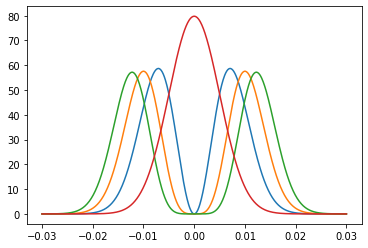

In [11]:
sigma = 0.005

plt.plot(x, np.array(list(map(lambda theta: normal_moment_prior_density(theta, sigma=sigma, k=1), x))))
plt.plot(x, np.array(list(map(lambda theta: normal_moment_prior_density(theta, sigma=sigma, k=2), x))))
plt.plot(x, np.array(list(map(lambda theta: normal_moment_prior_density(theta, sigma=sigma, k=3), x))))
plt.plot(x, norm.pdf(x, 0, sigma))

/Users/bryan.liu/.local/share/virtualenvs/non_local_prior-r3VUH6Cb/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


(0.0, 200.0)

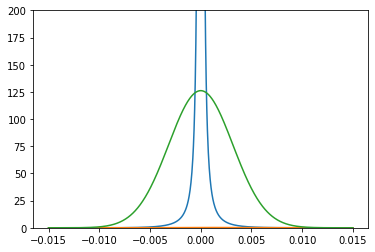

In [26]:
x = np.linspace(-0.015,0.015, 1001)

sigma = 0.005
N_E = 100000

plt.plot(x, norm.pdf(x, 0, np.sqrt(1 / N_E)) /
            (np.array(list(map(lambda theta: normal_moment_prior_density(theta, sigma=sigma, k=1), x)))))
plt.plot(x, norm.pdf(x, 0, 1 / (np.sqrt(sigma ** 2 + 1 / N_E)) / norm.pdf(x, 0, np.sqrt(1 / N_E))))

plt.plot(x, norm.pdf(x, 0, np.sqrt(1 / N_E)))

plt.ylim(0, 200)

Difference between an inverse gamma and inverse moment prior

In [22]:
def inverse_moment_prior(theta:float, nu:float, tau:float, k:int=1, theta_0:float=0):
    
    # Guard against zero division error in the negative power term 
    # if theta == theta_0
    if theta == theta_0:
        return 0
    
    dist = (theta - theta_0) ** 2
    
    return(
        k * tau ** (nu / 2.0) /
        gamma(nu / (2 * k)) *
        np.power(dist, -(nu+1)/2) *
        np.exp(-1.0 * (dist / tau) ** (-k))
    )

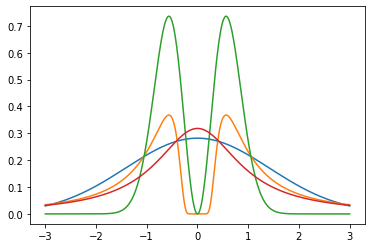

In [41]:
plt.plot(x, norm.pdf(x, 0, np.sqrt(2)))
plt.plot(x, np.array(list(map(lambda theta: inverse_moment_prior(theta, nu=1, tau=0.318, k=1), x))))
plt.plot(x, np.array(list(map(lambda theta: normal_moment_prior_density(theta, sigma=np.sqrt(0.159), k=1), x))))
plt.plot(x, cauchy.pdf(x))

In [12]:
def likelihood_normal_moment1(delta:float, mu_0:float=0, V:float=1., N_E:float=100.):
    """
    Likelihood function f(delta|mu) where mu is the normal moment prior with k=1.
    Recap: delta~N(mu,1/N_E), mu~NMP(theta_0=mu_0, sigma^2=V^2, k=1)
    """
    delta_var = V**2 + 1/N_E
    return(
        norm.pdf(delta, mu_0, np.sqrt(delta_var)) / delta_var *
        ((delta - mu_0) ** 2 * V ** 2 / delta_var + 1 / N_E)
    )


def likelihood_normal(delta:float, mu_0:float=0, V:float=1., N_E:float=100.):
    """
    Likelihood function f(delta|mu) where mu is the normal prior.
    Recap: delta~N(mu,1/N_E), mu~N(mu_0, V^2)
    """
    return norm.pdf(delta, mu_0, np.sqrt(V**2 + 1/N_E))


def likelihood_0(delta:float, mu_0:float=0, N_E:float=100., **kwargs):
    """
    Likelihood function f(delta|mu) for the null hypothesis where mu=0.
    Recap: delta~N(0, 1/N_E)
    """
    return norm.pdf(delta, mu_0, np.sqrt(1/N_E))

(0.0, 20.0)

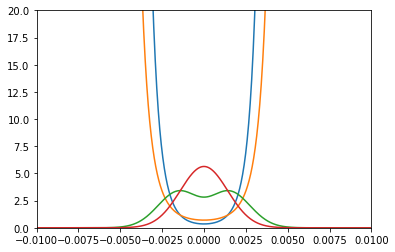

In [63]:
x = np.linspace(-0.015,0.015, 1001)

sigma = 0.001
N_E = 1000000

plt.plot(x, np.array(list(map(lambda delta: likelihood_normal_moment1(delta, mu_0=0, V=sigma, N_E=N_E), x))) /
            np.array(list(map(lambda delta: likelihood_0(delta, mu_0=0, N_E=N_E), x))))
plt.plot(x, np.array(list(map(lambda delta: likelihood_normal(delta, mu_0=0, V=sigma, N_E=N_E), x))) / 
            np.array(list(map(lambda delta: likelihood_0(delta, mu_0=0, N_E=N_E), x))))

plt.plot(x, np.array(list(map(lambda delta: likelihood_normal_moment1(delta, mu_0=0, V=sigma, N_E=N_E) / 50, x))))
plt.plot(x, np.array(list(map(lambda delta: likelihood_normal(delta, mu_0=0, V=sigma, N_E=N_E) / 50, x))))

plt.xlim(-0.01, 0.01)
plt.ylim(0, 20)

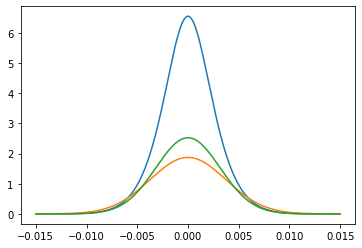

In [138]:
x = np.linspace(-0.015,0.015, 1001)
sigma = 0.005
N_E = 100000

plt.plot(x, np.array(list(map(lambda delta: likelihood_0(delta, mu_0=0, N_E=N_E), x))) /
            np.array(list(map(lambda delta: likelihood_normal_moment1(delta, mu_0=0, V=sigma, N_E=N_E), x))))
plt.plot(x, np.array(list(map(lambda delta: likelihood_0(delta, mu_0=0, N_E=N_E), x))) /
            np.array(list(map(lambda delta: likelihood_normal(delta, mu_0=0, V=sigma, N_E=N_E), x))))

plt.plot(x, np.array(list(map(lambda delta: likelihood_0(delta, mu_0=0, N_E=N_E) / 50, x) )))

In [43]:
def BF_0_1L(delta, mu_0, V, N_E):
    return likelihood_0(delta, mu_0=0, N_E=N_E)/likelihood_normal(delta, mu_0=0, V=V, N_E=N_E)

def BF_0_1M(delta, mu_0, V, N_E):
    return likelihood_0(delta, mu_0=0, N_E=N_E)/likelihood_normal_moment1(delta, mu_0=0, V=V, N_E=N_E)

def BF_1L_0(delta, mu_0, V, N_E):
    return likelihood_normal(delta, mu_0=0, V=V, N_E=N_E)/likelihood_0(delta, mu_0=0, N_E=N_E)

def BF_1M_0(delta, mu_0, V, N_E):
    return likelihood_normal_moment1(delta, mu_0=0, V=V, N_E=N_E)/likelihood_0(delta, mu_0=0, N_E=N_E)


In [15]:
sigma = 0.005
N_E = 10

x = np.random.normal(0, np.sqrt(1/N_E), 10000)

vSqNE = sigma ** 2 * N_E

B_01L_empirical = np.mean(list(map(lambda delta: BF_0_1L(delta, mu_0=0, V=sigma, N_E=N_E), x)))
B_01L_theoretical = (vSqNE + 1) / np.sqrt(2 * vSqNE + 1)

B_01M_empirical = np.mean(list(map(lambda delta: BF_0_1M(delta, mu_0=0, V=sigma, N_E=N_E), x)))
B_01M_theoretical = (
    (vSqNE + 1) / np.sqrt(2 * vSqNE + 1) *
    np.sqrt(np.pi/2) *
    np.sqrt(2 * (vSqNE) ** 2 + 3 * vSqNE + 4 + 1 / vSqNE) *
    erfcx(np.sqrt(1 + 1 / (2 * vSqNE)))
)

print("If delta|H_0:")
print(f"B_01L empirical: {B_01L_empirical}, B_01L theoretical: {B_01L_theoretical}.")
print(f"B_01M empirical: {B_01M_empirical}, B_01M theoretical: {B_01M_theoretical}.")

If delta|H_0:
B_01L empirical: 1.000002808401882, B_01L theoretical: 1.0000000312343824.
B_01M empirical: 1.000008602203732, B_01M theoretical: 1.0000002183913883.


In [100]:
sigma = 0.005
N_E = 100000

q = 0.0001

# x = np.random.normal(0, np.sqrt(sigma**2 + 1/N_E), 1000)

x = truncnorm.rvs(norm.ppf(q, 0, 1), norm.ppf(1-q, 0, 1), size=1000000) * np.sqrt(sigma**2 + 1/N_E)

B_1L0_empirical = np.mean(list(map(lambda delta: BF_1L_0(delta, mu_0=0, V=sigma, N_E=N_E), x)))
B_1L0_theoretical = (
    1 / np.sqrt(sigma**4 * N_E ** 2 - 1) * 
    erfi(norm.ppf(1 - q, 0, 1) * np.sqrt((sigma ** 2 * N_E - 1)/2)))

print("If delta|H_1:")
print(f"B_1L0 empirical: {B_1L0_empirical}, B_1L0 theoretical: {B_1L0_theoretical}.")

If delta|H_1:
B_1L0 empirical: 2573.181000680031, B_1L0 theoretical: 2587.899779902985.


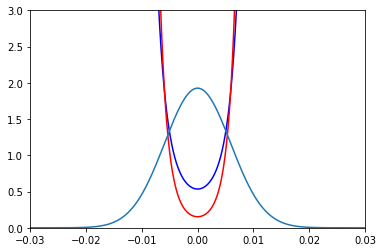

In [126]:
sigma = 0.005
N_E = 100000

x = np.linspace(-0.05,0.05, 10001)
plt.plot(x, np.array(list(map(lambda delta: BF_1L_0(delta, mu_0=0, V=sigma, N_E=N_E), x))), color='blue')
plt.plot(x, np.array(list(map(lambda delta: BF_1M_0(delta, mu_0=0, V=sigma, N_E=N_E), x))), color='red')
# plt.plot(x, np.array(list(map(lambda delta: 1/ BF_1L_0(delta, mu_0=0, V=sigma, N_E=N_E), x))), color='blue')
# plt.plot(x, np.array(list(map(lambda delta: 1/ BF_1M_0(delta, mu_0=0, V=sigma, N_E=N_E), x))), color='red')
plt.plot(x, np.array(list(map(lambda delta: norm.pdf(delta, 0, np.sqrt(sigma**2 + 1/N_E)) / 35, x))))

plt.xlim(-0.03, 0.03)
plt.ylim(0, 3)
plt.show()

In [49]:
BF_1L_0(0.01, mu_0=0, V=sigma, N_E=N_E)

0.9977019558330023

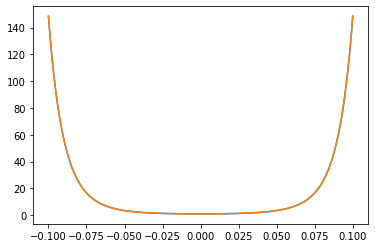

In [59]:
x = np.linspace(-0.1,0.1, 10001)

plt.plot(x, np.array(list(map(lambda delta: np.exp(-1/2 * delta ** 2 / (-0.001)), x))))
plt.plot(x, np.array(list(map(lambda delta: 1/ (np.exp(-1/2 * delta ** 2 / (0.001))), x))))

plt.show()

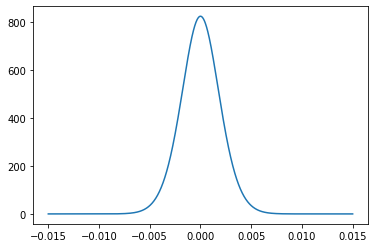

In [136]:
# x = np.linspace(-0.05,0.05, 10001)

bf_normal_variance = (sigma**2 + 1/N_E) / (2 * N_E * sigma**2 + 1)
# print(bf_normal_variance)

# plt.plot(x, np.array(list(map(lambda delta: 1/ (delta**2 * sigma**2/(sigma**2 + 1/N_E) + 1/N_E), x) )))

plt.plot(x, np.array(list(map(lambda delta: norm.pdf(delta, 0, np.sqrt(bf_normal_variance)) / 
                              (delta**2 * sigma**2/(sigma**2 + 1/N_E) + 1/N_E) *
                              (sigma**2 * N_E + 1)*(sigma**2 + 1/N_E) / np.sqrt(2*sigma**2*N_E + 1), x) )))

# plt.xlim(-0.1, 0.1)
# plt.ylim(0, 10000)

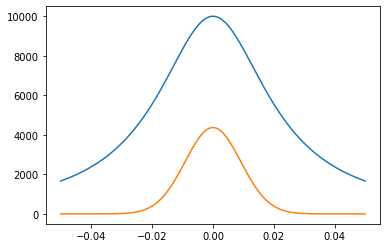

In [145]:
mu = 0
sigma=0.005
N_E = 10000

x = np.linspace(-0.05,0.05, 10001)

plt.plot(x, np.array(list(map(lambda delta: 1 / (delta**2 * sigma**2 / (sigma**2 + 1/N_E) + 1/N_E), x) )))
plt.plot(x, np.array(list(map(lambda delta: norm.pdf(delta, 0, 
                                                     np.sqrt((sigma**2 + 1/N_E)/(2 * sigma**2 * N_E + 1))) * 100, x))))

plt.show()

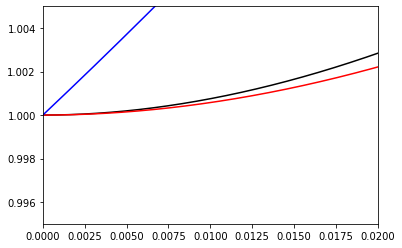

In [8]:
x = np.linspace(0.00001, 5, 500000)
# x = np.linspace(-0.5, 0.000001, 50000)

plt.plot(x,
         np.array(list(map(
             lambda y: (2 + 1/y) * (y + 1) ** 2 * np.pi / 2 * erfcx(np.sqrt(1 + 1 / (2 * y))) ** 2,
             x
         ))), c='black')

plt.plot(x,
         np.array(list(map(
             lambda y: (2 + 1/y) * (y + 1) ** 2 * np.pi / 2 * 
             (2 / np.sqrt(np.pi) / (np.sqrt(1+1/(2*y)) + np.sqrt(3 + 1/(2*y)))) ** 2,
             x
         ))), c='red')

plt.plot(x,
         np.array(list(map(
             lambda y: (2 + 1/y) * (y + 1) ** 2 * np.pi / 2 * 
             (2 / np.sqrt(np.pi) / (np.sqrt(1+1/(2*y)) + np.sqrt(4/np.pi + 1 + 1/(2*y)))) ** 2,
             x
         ))), c='blue')

plt.ylim(0.995, 1.005)
plt.xlim(0, 0.02)
plt.show()

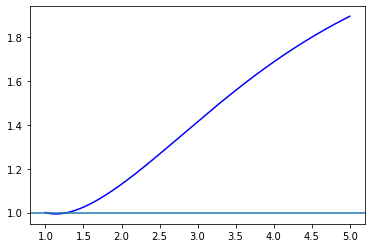

In [202]:
x = np.linspace(1.00001, 5, 10001)

quantile = 1 - 0.05

plt.plot(x, np.array(list(map(
             lambda v2ne: norm.ppf(quantile) * np.sqrt((v2ne - 1.0)/2) /
                          v2ne / dawsn(norm.ppf(quantile) * np.sqrt((v2ne - 1.0) / 2)),
             x
         ))), c='blue')

# plt.plot(x, np.array(list(map(
#              lambda v2ne: norm.ppf(quantile) * np.sqrt((v2ne - 1.0)/2) /
#                           dawsn(norm.ppf(quantile) * np.sqrt((v2ne - 1.0) / 2)),
#              x
#          ))), c='red')

# plt.plot(x, np.array(list(map(
#              lambda v2ne: v2ne,
#              x
#          ))), c='green')

plt.axhline(1)


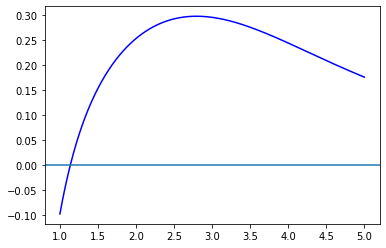

In [206]:
x = np.linspace(1.00001, 5, 10001)

quantile = 1 - 0.05

plt.plot(x, np.array(list(map(
             lambda v2ne: norm.ppf(quantile) / np.sqrt(2) / v2ne /
                          dawsn(norm.ppf(quantile) * np.sqrt((v2ne - 1.0) / 2)) *
                          (1/2/np.sqrt(v2ne-1) - np.sqrt(v2ne-1)/v2ne -
                           np.sqrt(2)/4*norm.ppf(quantile)/ dawsn(norm.ppf(quantile) * np.sqrt((v2ne - 1.0) / 2))+ 
                           1/2 * np.sqrt(v2ne-1)*norm.ppf(quantile)**2),
             x
         ))), c='blue')

plt.axhline(0)

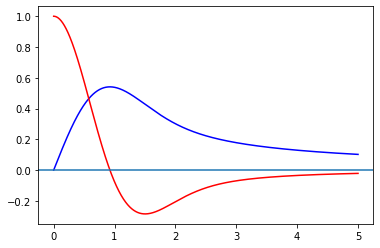

In [197]:
x = np.linspace(0, 5, 10001)

quantile = 1 - 0.01

# plt.plot(x, x / dawsn(x), c='blue')

plt.plot(x, dawsn(x), c='blue')
plt.plot(x, (1 - 2*x * dawsn(x)), c='red')
plt.axhline(0)

# plt.plot(x, x/dawsn(x), c='red')